In [127]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from raw_utils import *
from alignment import *
import rawpy
from dataset_navigation import get_image_paths

In [128]:
paths = get_image_paths()
print(paths.keys())


{'photo_8.CR2', 'photo_33.CR2'}
dict_keys(['filter_long_exp', 'long_exp', 'short_exp'])


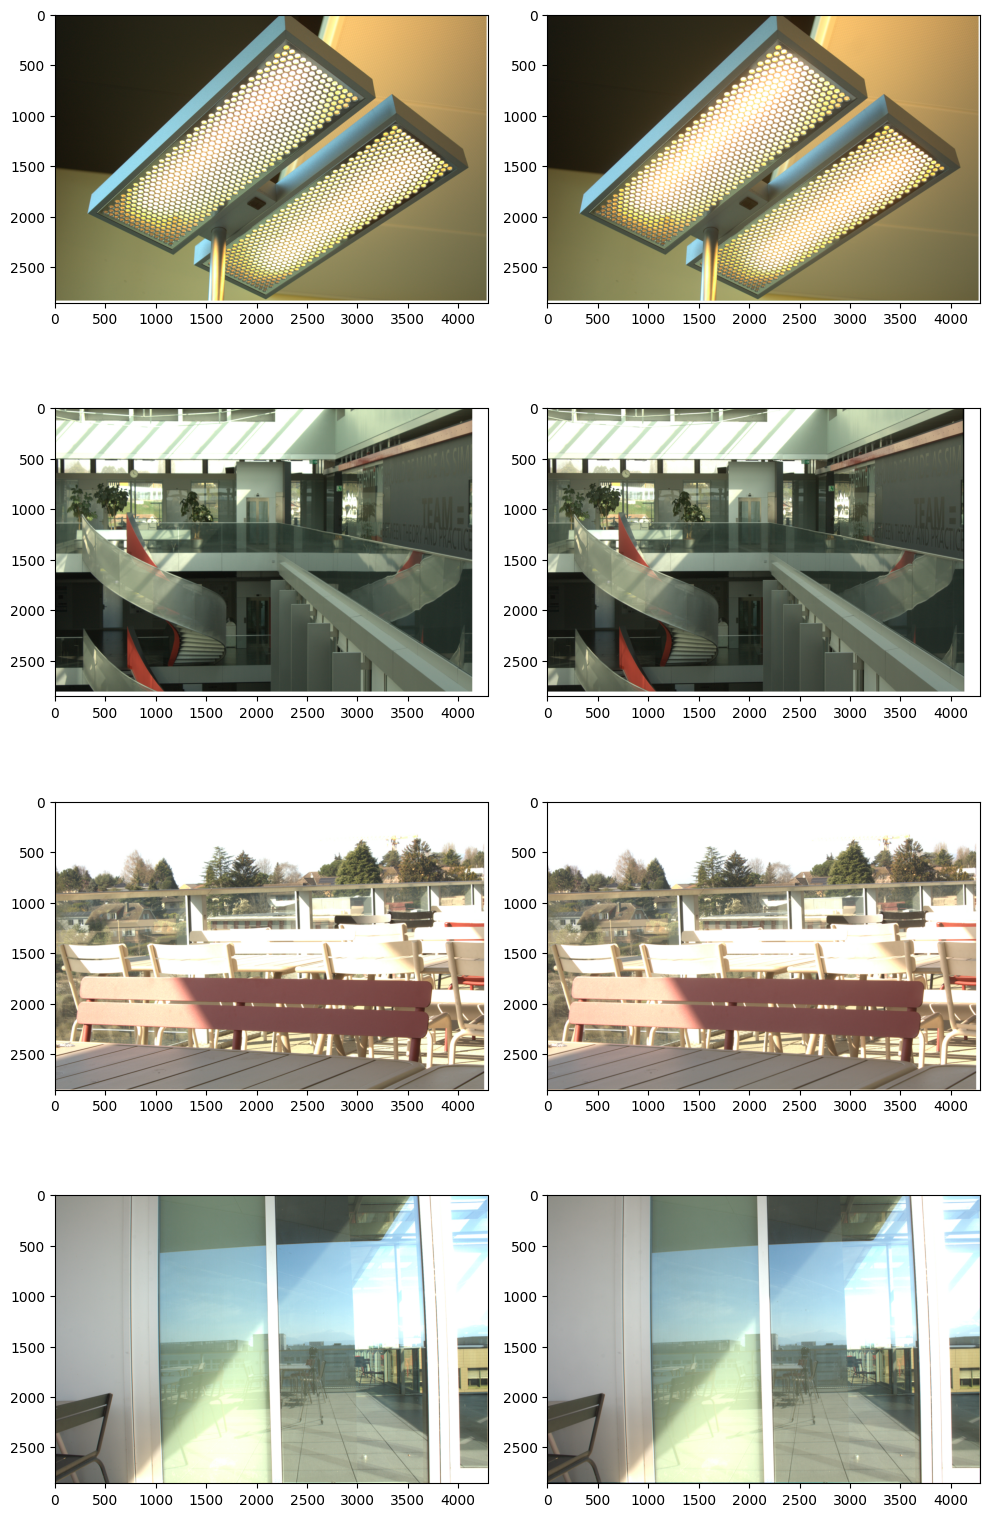

In [129]:

n = 4
fig, axs = plt.subplots(n,2, figsize=(10,4*n))
unfiltered_paths = paths['long_exp']
filtered_paths = paths['filter_long_exp']
for i in range(n):
    # unfiltered = rawpy.imread(unfiltered_paths[i]).postprocess()
    unfiltered, filtered = align_and_crop_raw_images(unfiltered_paths[i], filtered_paths[i])
    unfiltered_postprocessed = unfiltered['raw'].postprocess()
    filtered_postprocessed = filtered['raw'].postprocess()
    axs[i,0].imshow(unfiltered_postprocessed)
    # filtered = rawpy.imread(filtered_paths[i]).postprocess()
    axs[i,1].imshow(filtered_postprocessed)
fig.tight_layout()
plt.show()



# return_original = {"raw": original_image_raw, "mosaic_array": original_image_array, "channels": cropped_original}
# return_aligned = {"raw": aligned_image_raw, "mosaic_array": aligned_image_array, "channels": cropped_aligned}

# return return_original, return_aligned

In [130]:


def compute_local_variance_single_channel(image, kernel_size=5):
    image = image.astype(np.float32)
    # cv2 blur calculates local mean using a box filter
    mean = cv2.blur(image, (kernel_size, kernel_size))
    mean_sq = cv2.blur(image**2, (kernel_size, kernel_size))
    variance = mean_sq - mean**2
    return mean_sq - mean**2

def compute_local_variance(image, kernel_size=5):
    R_variance = compute_local_variance_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_variance_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_variance_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_variance_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)

def compute_local_mean_single_channel(image, kernel_size=5):
    image = image.astype(np.float32)
    # cv2 blur calculates local mean using a box filter
    mean = cv2.blur(image, (kernel_size, kernel_size))
    return mean

def compute_local_mean(image, kernel_size=5):
    R_variance = compute_local_mean_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_mean_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_mean_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_mean_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)

In [113]:


def create_array_per_pair(image, variance_difference):
    image = image.flatten()
    variance_difference = variance_difference.flatten()
    if image.shape != variance_difference.shape:
        raise ValueError("Inputs must have the same shape after flattening.")
    paired_array = np.stack((image, variance_difference), axis=1)
    return paired_array

def average_y_per_x(paired_array, threshold=0):
    x = paired_array[:, 0]
    y = paired_array[:, 1]
    unique_x, inverse_indices = np.unique(x, return_inverse=True)
    sum_y = np.bincount(inverse_indices, weights=y)
    count_y = np.bincount(inverse_indices)
    avg_y = sum_y / count_y
    # Apply threshold
    mask = count_y >= threshold
    filtered_x = unique_x[mask]
    filtered_avg_y = avg_y[mask]

    return np.stack((filtered_x, filtered_avg_y), axis=1)

def average_y_per_x_binned(paired_array, num_bins=100, threshold=0):
    x = paired_array[:, 0]
    y = paired_array[:, 1]

    # Create bins
    x_min, x_max = x.min(), x.max()
    bins = np.linspace(x_min, x_max, num_bins + 1)

    # Assign each x to a bin
    bin_indices = np.digitize(x, bins) - 1  # shift to 0-based index

    # Remove out-of-range values
    valid_mask = (bin_indices >= 0) & (bin_indices < num_bins)
    bin_indices = bin_indices[valid_mask]
    y = y[valid_mask]

    # Compute average y per bin
    sum_y = np.bincount(bin_indices, weights=y, minlength=num_bins)
    count_y = np.bincount(bin_indices, minlength=num_bins)
    avg_y = np.divide(sum_y, count_y, out=np.zeros_like(sum_y), where=count_y > 0)

    # Apply threshold
    mask = count_y >= threshold
    bin_centers = (bins[:-1] + bins[1:]) / 2
    filtered_x = bin_centers[mask]
    filtered_avg_y = avg_y[mask]

    return np.stack((filtered_x, filtered_avg_y), axis=1)



In [115]:
from dataset_navigation import get_image_paths
from tqdm import tqdm
paths_dict = get_image_paths()
# n = 2
# diffused_image_paths = paths_dict['filter_long_exp'][:n]
# clear_image_paths = paths_dict['long_exp'][:n]

diffused_image_paths = paths_dict['filter_long_exp']
clear_image_paths = paths_dict['long_exp']


pixel_to_variance_difference_r = np.zeros((0,2))
pixel_to_mean_difference_r = np.zeros((0,2))
pixel_to_variance_difference_normalized_r = np.zeros((0,2))
pixel_to_variance_clear_r = np.zeros((0,2))
pixel_to_variance_diffused_r = np.zeros((0,2))

for diffused_image_path, clear_image_path in tqdm(zip(diffused_image_paths, clear_image_paths), total=len(diffused_image_paths)):
    clear, diffused = align_and_crop_raw_images(clear_image_path, diffused_image_path)
    clear_channels = clear['channels']
    diffused_channels = diffused['channels']
    clear_variance = compute_local_variance(clear_channels)
    diffused_variance = compute_local_variance(diffused_channels)
    clear_mean = compute_local_mean(clear_channels)
    diffused_mean = compute_local_mean(diffused_channels)
    mean_difference = (diffused_mean - clear_mean)
    variance_difference_normalized = (diffused_variance - clear_variance ) / ( clear_variance + diffused_variance + 1e-8)
    variance_difference = (diffused_variance - clear_variance)
    pixel_to_mean_difference_r = np.append(pixel_to_mean_difference_r, create_array_per_pair(clear_channels[:,:,0], mean_difference[:,:,0]), axis=0)
    pixel_to_variance_difference_r = np.append(pixel_to_variance_difference_r, create_array_per_pair(clear_channels[:,:,0], variance_difference[:,:,0]), axis=0)
    pixel_to_variance_difference_normalized_r = np.append(pixel_to_variance_difference_normalized_r, create_array_per_pair(clear_channels[:,:,0], variance_difference_normalized[:,:,0]), axis=0)
    pixel_to_variance_clear_r = np.append(pixel_to_variance_clear_r, create_array_per_pair(clear_channels[:,:,0], clear_variance[:,:,0]), axis=0)
    pixel_to_variance_diffused_r = np.append(pixel_to_variance_diffused_r, create_array_per_pair(clear_channels[:,:,0], diffused_variance[:,:,0]), axis=0)
print(pixel_to_variance_difference_r.shape)

{'photo_8.CR2', 'photo_33.CR2'}


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

(5933610, 2)


In [131]:
def plot_scatter(paired_array, ax, xlabel="", ylabel="", title=""):
    x = paired_array[:, 0]
    y = paired_array[:, 1]
    ax.scatter(x, y, s=1, alpha=0.8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

def plot_avg_variance_difference_by_pixel_1_channel(variance_difference_by_pixel_compared_to_original, threshold=0, ax=None):
    # avg_variance_by_pixel_compared_to_original = average_y_per_x(variance_difference_by_pixel_compared_to_original, threshold=threshold)
    avg_variance_by_pixel_compared_to_original = average_y_per_x_binned(variance_difference_by_pixel_compared_to_original, num_bins=500, threshold=threshold)
    if ax is None:
        fig, ax = plt.subplots()
    plot_scatter(avg_variance_by_pixel_compared_to_original, ax, "Pixel intensity", "Avg variance difference", "Avg variance difference by pixel intensity")

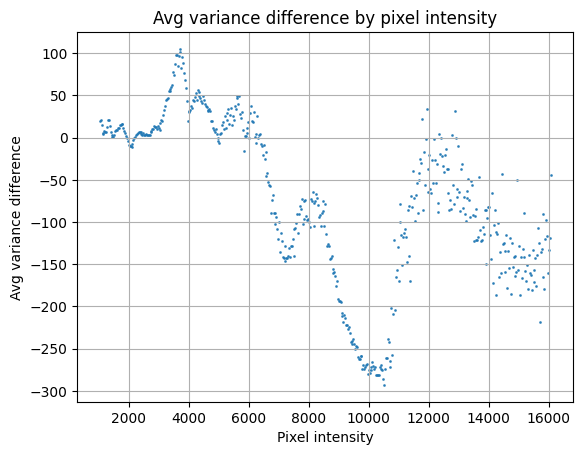

In [121]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_mean_difference_r)


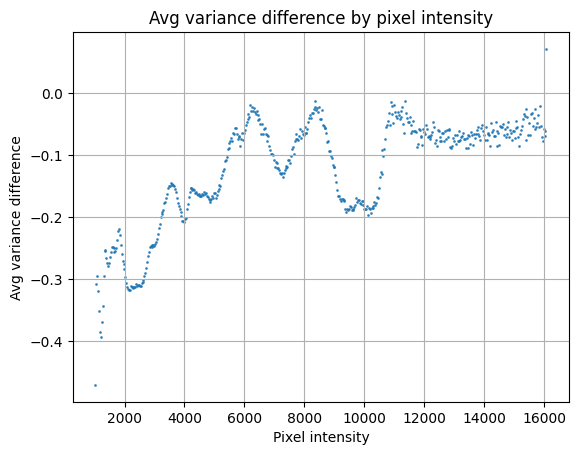

In [122]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_difference_normalized_r)

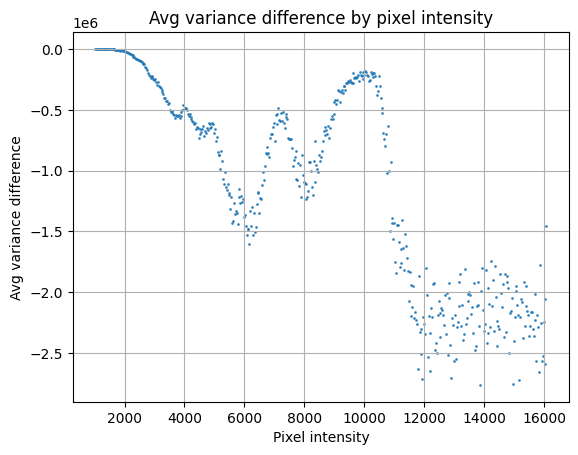

In [123]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_difference_r)


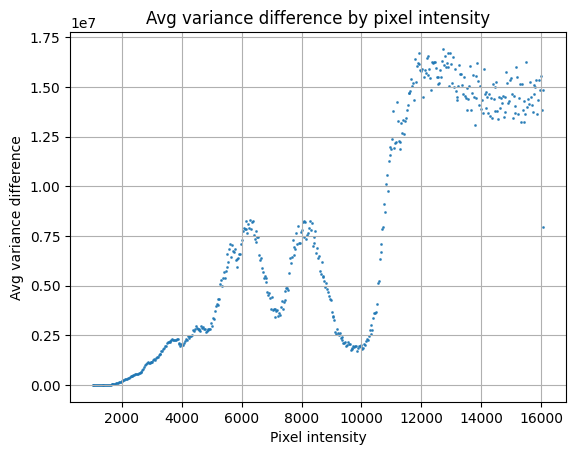

In [124]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_clear_r)

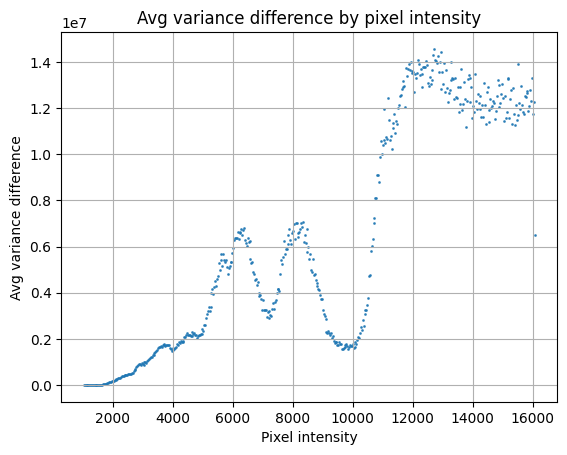

In [125]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_diffused_r)


3425.1039229069656
3573.173320990166
985.0
16085.0


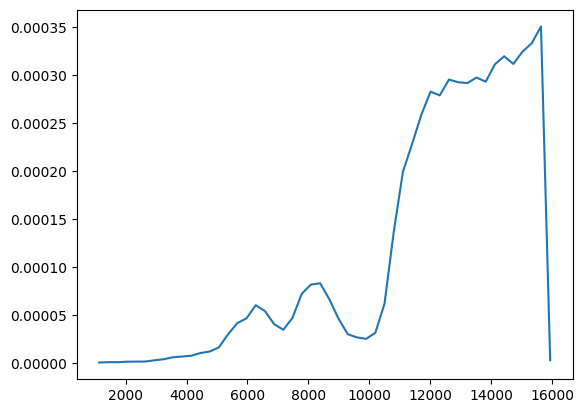

In [126]:

# simply plot avg brightness histogram
print(pixel_to_variance_difference_r[:, 0].mean())
print(pixel_to_variance_difference_r[:, 0].std())
print(pixel_to_variance_difference_r[:, 0].min())
print(pixel_to_variance_difference_r[:, 0].max())
num_bins = 50

counts, bin_edges = np.histogram(pixel_to_variance_difference_r[:, 0], bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)

# Plot as points
plt.plot(bin_centers, inv_counts)
# plt.hist(pixel_to_variance_difference_r[:, 0], bins=num_bins)
# plt.plot(bins, hist)
plt.show()  

136139.47666833425
929806.6111278353
0.0
62094540.0


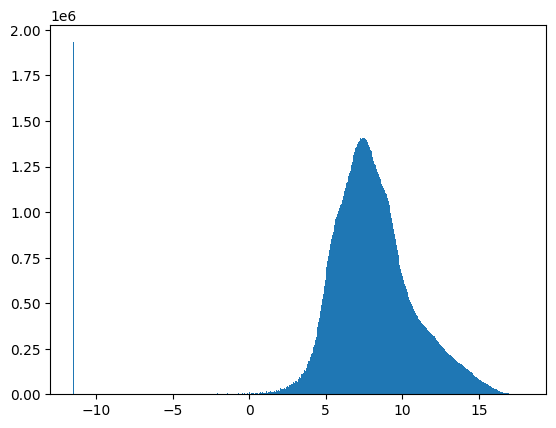

np.float64(3269017.3724721107)

In [74]:
# simply plot avg variance histogram
print(pixel_to_variance_difference_r[:,1].mean())
print(pixel_to_variance_difference_r[:,1].std())
print(pixel_to_variance_difference_r[:,1].min())
print(pixel_to_variance_difference_r[:,1].max())
# plt.hist(pixel_to_variance_difference_r[:,1]+0.00001, bins=50)
plt.hist(np.log(pixel_to_variance_difference_r[:,1]+0.00001), bins=500)
plt.show()


3637.2261693860833
3216.038344820561
872.0
16088.0


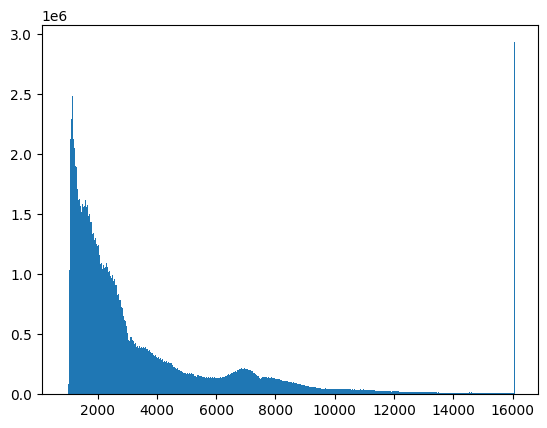